#  WGAN-GP MNIST Overdrive: The Ultimate Pixel Showdown

Welcome to the **WGAN-GP MNIST Overdrive** notebook! In this project, I build and train a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** using the MNIST dataset to generate realistic handwritten digits. Here's what this notebook covers:

---

## What is MNIST?
- **MNIST Dataset:**  
  A benchmark dataset consisting of 60,000 training images and 10,000 testing images of handwritten digits (0-9). Each image is 28x28 pixels, grayscale.
  
---

## What is WGAN-GP?
- **Wasserstein GAN (WGAN):**  
  An improved version of GANs that uses the Earth Mover's (Wasserstein) distance as a loss metric instead of the standard Jensen–Shannon divergence. This leads to more stable training.
  
- **Gradient Penalty (GP):**  
  A regularization term added to the WGAN loss to enforce the Lipschitz constraint, leading to better convergence and more robust training.

---

## Notebook Workflow:
1. **Environment Setup & Imports:**  
   I set up TensorFlow with mixed precision for better performance, import all necessary libraries, and configure the logging and GPU settings.

2. **Visualization Utilities:**  
   Functions are defined to display grids of images and to monitor the training progress visually through callbacks.

3. **Data Loading & Preprocessing:**  
   The MNIST dataset is loaded and normalized to the range [-1, 1] – a typical preparation step for GAN training.

4. **Model Architectures:**  
   - **Generator:** Transforms random noise vectors into 28x28 grayscale images that resemble handwritten digits.
   - **Discriminator:** Evaluates whether an image is real (from MNIST) or generated (fake).

5. **WGAN-GP Training Loop:**  
   A custom training loop is implemented:
   - The **discriminator** is updated multiple times per iteration with a gradient penalty to enforce stable learning.
   - The **generator** is updated to maximize the discriminator's error.
   
6. **Results & Final Outputs:**  
   After training, we plot the discriminator and generator loss curves and display final generated samples.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2025-05-02 04:37:38.252551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746160658.495651      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746160658.560241      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# VISUALIZATION 

In [2]:
def show_images(images, n_rows=2, n_cols=5, figsize=(10,4), title=None):
    """Display a grid of grayscale images."""
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

class GANMonitor(tf.keras.callbacks.Callback):
    """Keras callback to generate and display images every N epochs."""
    def __init__(self, num_images=10, latent_dim=100, interval=500):
        self.num_images, self.latent_dim, self.interval = num_images, latent_dim, interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.interval == 0:
            z = np.random.normal(size=(self.num_images, self.latent_dim))
            gen_imgs = self.model.generator.predict(z)
            gen_imgs = 0.5 * gen_imgs + 0.5
            show_images(gen_imgs, title=f"Epoch {epoch+1}: Generated Samples")

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set the logging level before importing TensorFlow to avoid extra messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

# Enable mixed precision for improved performance
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Utilities & Gradient Penalty

In [4]:
def show_images(images, n_rows=2, n_cols=5, figsize=(10,4), title=None):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Gradient Penalty for WGAN-GP
def gradient_penalty(discriminator, real, fake):
    alpha = tf.random.uniform([real.shape[0], 1, 1, 1], 0., 1.)
    interp = real + alpha * (fake - real)
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interp)
        pred = discriminator(interp, training=True)
    grads = gp_tape.gradient(pred, interp)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
    return tf.reduce_mean((norm - 1.0) ** 2)

In [5]:
class MNISTLoader:
    def __init__(self):
        (x_train, _), _ = mnist.load_data()
        x_train = np.expand_dims(x_train, -1).astype('float32')
        self.data = (x_train - 127.5) / 127.5
        print(f"Loaded {self.data.shape[0]} images: {self.data.shape[1:]}.")
        
    def get_batch(self, batch_size):
        idx = np.random.randint(0, self.data.shape[0], batch_size)
        return self.data[idx]

# MODEL ARCHITECTURES 

In [6]:
def conv_block(filters, kernel_size=4, strides=2, activation=True):
    block = Sequential()
    block.add(layers.Conv2D(filters, kernel_size, strides=strides, padding='same'))
    if activation:
        block.add(layers.LeakyReLU(0.2))
    block.add(layers.Dropout(0.3))
    return block

def deconv_block(filters, kernel_size=4, strides=2):
    block = Sequential()
    block.add(layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same'))
    block.add(layers.BatchNormalization())
    block.add(layers.ReLU())
    return block

class Generator(Sequential):
    def __init__(self, z_dim=100):
        super().__init__(name='Generator')
        self.add(layers.Dense(7*7*256, input_dim=z_dim))
        self.add(layers.Reshape((7,7,256)))
        for f in [256, 128, 64]:
            self.add(deconv_block(f))
        self.add(layers.Conv2D(1, 7, padding='same', activation='tanh', dtype='float32'))

class Generator(Sequential):
    def __init__(self, z_dim=100):
        super().__init__(name='Generator')
        self.add(layers.InputLayer(shape=(z_dim,)))
        self.add(layers.Dense(7 * 7 * 256))
        self.add(layers.Reshape((7, 7, 256)))
        for f in [256, 128]:
            self.add(deconv_block(f))
        self.add(layers.Conv2D(1, 7, padding='same', activation='tanh', dtype='float32'))

class Discriminator(Sequential):
    def __init__(self):
        super().__init__(name='Discriminator')
        self.add(layers.InputLayer(shape=(28, 28, 1)))
        self.add(conv_block(64))
        self.add(conv_block(128))
        self.add(conv_block(256))
        self.add(layers.Flatten())
        self.add(layers.Dense(1, dtype='float32'))

# WGAN-GP Trainer

In [7]:
class WGAN_GP:
    def __init__(self, gen, disc, latent_dim, gp_weight=10.):
        self.generator = gen
        self.discriminator = disc
        self.latent_dim = latent_dim
        self.gp_weight = gp_weight
        self.gen_opt = Adam(1e-4, beta_1=0.0, beta_2=0.9)
        self.disc_opt = Adam(1e-4, beta_1=0.0, beta_2=0.9)
    
    @tf.function
    def train_step(self, real):
        bs = tf.shape(real)[0]
        # Discriminator updates
        for _ in range(5):
            noise = tf.random.normal([bs, self.latent_dim])
            with tf.GradientTape() as tape:
                fake = self.generator(noise, training=True)
                real_logits = self.discriminator(real, training=True)
                fake_logits = self.discriminator(fake, training=True)
                gp = gradient_penalty(self.discriminator, real, fake)
                d_loss = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits) + self.gp_weight * gp
            grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.disc_opt.apply_gradients(zip(grads, self.discriminator.trainable_variables))
        # Generator update
        noise = tf.random.normal([bs, self.latent_dim])
        with tf.GradientTape() as tape:
            fake = self.generator(noise, training=True)
            fake_logits = self.discriminator(fake, training=True)
            g_loss = -tf.reduce_mean(fake_logits)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_variables))
        return d_loss, g_loss
    
    def fit(self, loader, epochs=100, batch_size=64):
        d_losses, g_losses = [], []
        for _ in range(epochs):
            real = loader.get_batch(batch_size)
            d_loss, g_loss = self.train_step(real)
            d_losses.append(d_loss.numpy())
            g_losses.append(g_loss.numpy())
        return d_losses, g_losses

# Execution & Final Plots

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded 60000 images: (28, 28, 1).


I0000 00:00:1746160673.686893      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746160673.687539      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1746160692.117093      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


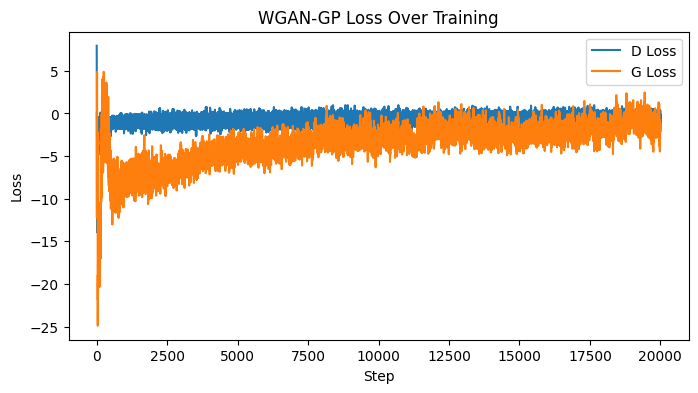

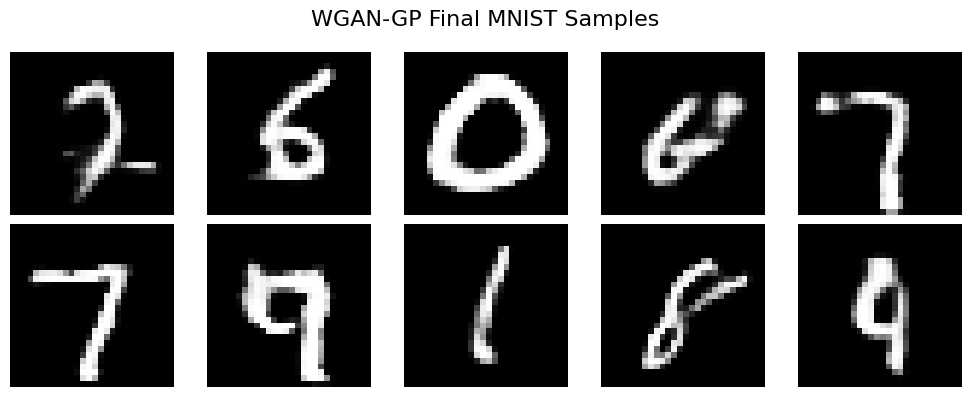

In [8]:
if __name__ == '__main__':
    Z_DIM, EPOCHS, BATCH = 128, 20000, 64
    loader = MNISTLoader()
    gen = Generator(z_dim=Z_DIM)
    disc = Discriminator()
    wgan = WGAN_GP(gen, disc, latent_dim=Z_DIM)
    
    d_losses, g_losses = wgan.fit(loader, epochs=EPOCHS, batch_size=BATCH)
    
    # LOSS CURVE
    plt.figure(figsize=(8,4))
    plt.plot(d_losses, label='D Loss')
    plt.plot(g_losses, label='G Loss')
    plt.title('WGAN-GP Loss Over Training')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # FINAL SAMPLES
    noise = tf.random.normal([10, Z_DIM])
    samples = wgan.generator(noise, training=False)
    samples = (samples + 1.) * 127.5
    show_images(samples.numpy().astype('uint8'), title="WGAN-GP Final MNIST Samples")